In [1]:
import torch
from pydantic import (
    BaseModel,
    Field,
    annotated_types,
    parse_obj_as,
    validator,
    root_validator,
)
from typing import Annotated
import torchvision
import json
import torch.nn as nn
from torchvision.models.detection.faster_rcnn import (
    FastRCNNPredictor,
    fasterrcnn_resnet50_fpn,
)
from courtvision.data import CourtVisionDataset


# dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

In [2]:
from courtvision.data import PadelDataset

dataset_name = "project-1-at-2023-05-03-17-56-05c2c1f7"
with open(
    f"/Users/benjamindecharmoy/projects/courtvision/datasets/annotations/{dataset_name}.json",
    "r",
) as fp:
    dataset = PadelDataset(samples=json.load(fp))

In [3]:
dataset

PadelDataset(samples=[CourtAnnotatedSample(idx=75, data=AnnotationDataPath(image=PosixPath('/data/upload/1/83dcc83f-curated_001_frame_0001.png')), annotations=[Annotation(unique_id='d8e3af3b-79fa-4936-8a63-afab8d0c9666', result=[GeneralResult(kind='keypointlabels', original_width=1280, original_height=720, value=KeypointValue(x=10.854503464203233, y=88.29568788501027, width=0.23094688221709006, keypointlabels=['a_front_left']), from_name='court_corners'), GeneralResult(kind='keypointlabels', original_width=1280, original_height=720, value=KeypointValue(x=89.7228637413395, y=88.29568788501027, width=0.23094688221709006, keypointlabels=['b_front_right']), from_name='court_corners'), GeneralResult(kind='keypointlabels', original_width=1280, original_height=720, value=KeypointValue(x=8.775981524249422, y=49.48665297741273, width=0.23094688221709006, keypointlabels=['m_top_front_left']), from_name='court_corners'), GeneralResult(kind='keypointlabels', original_width=1280, original_height=72

In [5]:
root = "/Users/benjamindecharmoy/projects/courtvision/data/frames"
dd = CourtVisionDataset(dataset=dataset, root=root)

torch.Size([1, 1, 4])


1

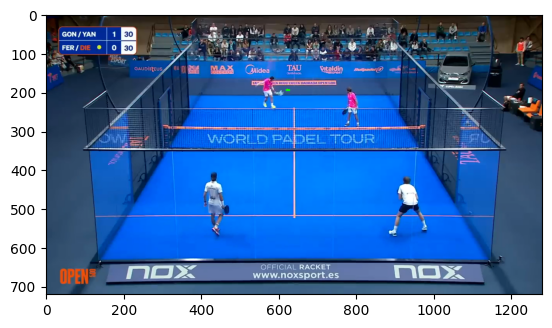

In [8]:
sample, image = dd[2]
CourtVisionDataset.show_sample(annotation=sample.annotations, image=image)
len(sample.annotations)

In [60]:
dataset.samples[0].annotations

[Annotation(unique_id='d8e3af3b-79fa-4936-8a63-afab8d0c9666', result=[GeneralResult(kind='keypointlabels', original_width=1280, original_height=720, value=KeypointValue(x=10.854503464203233, y=88.29568788501027, width=0.23094688221709006, keypointlabels=['a_front_left']), from_name='court_corners'), GeneralResult(kind='keypointlabels', original_width=1280, original_height=720, value=KeypointValue(x=89.7228637413395, y=88.29568788501027, width=0.23094688221709006, keypointlabels=['b_front_right']), from_name='court_corners'), GeneralResult(kind='keypointlabels', original_width=1280, original_height=720, value=KeypointValue(x=8.775981524249422, y=49.48665297741273, width=0.23094688221709006, keypointlabels=['m_top_front_left']), from_name='court_corners'), GeneralResult(kind='keypointlabels', original_width=1280, original_height=720, value=KeypointValue(x=91.22401847575058, y=49.07597535934291, width=0.23094688221709006, keypointlabels=['n_top_front_right']), from_name='court_corners')])

In [9]:
head = FastRCNNPredictor(384, 2)

In [10]:
patch_embed, mod_list = list(dinov2_vits14.children())[:-2]
patch_embed, mod_list

list(mod_list.children())[1:2]

NameError: name 'dinov2_vits14' is not defined

In [11]:
head(nn.Sequential(*[patch_embed, *mod_list[:]])(torch.rand(1, 3, 224, 224))).shape

NameError: name 'patch_embed' is not defined

In [ ]:
fast_model = fasterrcnn_resnet50_fpn(
    pretrained=True,
    num_classes=91,
)
fast_model

/Users/benjamindecharmoy/projects/courtvision/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/benjamindecharmoy/projects/courtvision/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
from courtvision.vis import load_timg

image = load_timg(
    "/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/frame_0001.png"
)
with torch.no_grad():
    # fast_model.backbone.body = nn.Sequential(*[patch_embed, *mod_list[:]])
    # fast_model.roi_heads.box_predictor = head
    fast_model.eval()
    out = fast_model(image)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
with torch.no_grad():
    # fast_model.backbone.body = nn.Sequential(*[patch_embed, *mod_list[:]])
    # fast_model.roi_heads.box_predictor = head
    model.eval()
    out = model(image)

In [ ]:
import rerun as rr
from rerun.components.rect2d import RectFormat

rr.init("faster", spawn=True)

In [ ]:
rr.log_rigid3(entity_path="frame/test", parent_from_child=([0, 10, 0], [0, 111, 0, 10]))

In [ ]:
rr.log_image("frame/test/img", image.squeeze(0).permute(1, 2, 0))
# out[0]["boxes"]

In [ ]:
dd = [box.tolist() for box in out[0]["boxes"]]
rr.log_rects("frame/boxes", dd, rect_format=RectFormat.XYXY)

In [ ]:
from rerun.components.rect2d import RectFormat

rr.log_rect("frame/box", out[0]["boxes"][2].tolist(), rect_format=RectFormat.XYXY)

In [ ]:
out[0]["boxes"][0].tolist()

[586.6439819335938, 360.8269348144531, 1062.5076904296875, 670.1864624023438]

In [ ]:
image.shape

torch.Size([1, 3, 720, 1280])

In [ ]:
out[0]

{'boxes': tensor([[ 586.6440,  360.8269, 1062.5077,  670.1865],
         [ 597.6040,  191.3133,  617.9384,  211.2779],
         [ 297.4283,  581.7656, 1115.0757,  708.7494],
         [ 389.4426,  128.8055,  970.5952,  490.9042],
         [ 434.5761,  284.2084,  946.3016,  621.3353],
         [ 761.4454,  195.3744,  802.9850,  293.6284],
         [ 428.8613,  451.5882,  473.8964,  573.3542],
         [ 821.0404,  284.2837, 1154.2217,  720.0000],
         [ 898.5524,  426.9127,  946.2028,  537.3666],
         [ 416.9436,  498.2014, 1103.0070,  664.2693],
         [ 878.7841,  415.2511,  968.8537,  574.6574],
         [ 757.9148,   17.3750,  977.1315,  369.8183],
         [ 763.1102,  232.0803,  817.0454,  287.9791],
         [ 573.9623,  174.1141,  595.5928,  222.5417],
         [ 588.5248,  189.3533,  609.8690,  209.1296],
         [ 406.5399,   64.9292,  815.7542,  349.9398],
         [ 471.6840,   19.7566,  897.4198,  720.0000],
         [1229.1489,  222.3493, 1280.0000,  271.0620],
 

In [ ]:
import label_studio

ModuleNotFoundError: No module named 'label_studio'